In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import rdchiral.main as rdc
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

from falsify_data import removemap
from utils import *

In [2]:
df = pd.read_csv('cleaned_uspto50k.csv')
rxn_smiles = list(df['rxn_smiles'])
retro_templates = list(df['retro_template'].drop_duplicates())
print(len(retro_templates))

13761


# METHOD 1 - STRICT

In [3]:
num_possible_pts_list = []
false_rxn_dict = {
    'rxn_smiles': [],
    'label': [],
    'true_rxn_smiles': [],
    'forward_template': []
}
for i in tqdm(range(len(df))):
    rxn = rxn_smiles[i]
    rxn = removemap(rxn)
    rt, pt = rxn2rtpt(rxn)
    rule = reverse_temp(retro_templates[i])
    possible_pts = rdc.rdchiralRunText(rule, rt)

    # if `rdc.rdchiralRunText` cannot handle
    # and return empty list,
    # let original `RunReactants` from rdkit do the work
    if len(possible_pts) == 0:
        rt_list = rt.split('.')
        rt_mol_list = [Chem.MolFromSmiles(smi) for smi in rt_list]
        possible_pts_mol = AllChem.ReactionFromSmarts(rxn).RunReactants(rt_mol_list)
        for possible_pt in possible_pts_mol:
            # possible_pt is a tuple of rdkit mol objects
            possible_pts.append('.'.join([Chem.MolToSmiles(mol) for mol in possible_pt]))

    # remove duplicates from possible_pts (if any)
    possible_pts = list(set(possible_pts))
    num_possible_pts_list.append(len(possible_pts))

    # look for false reactions
    for possible_pt in possible_pts:
        # for possible product that is not the recorded product
        # we take it as a negative product
        # and the corresponding reaction as a negaitve sample
        if possible_pt != pt:
            false_rxn = f'{rt}>>{possible_pt}'

            # dump essential info into dict
            false_rxn_dict['rxn_smiles'].append(false_rxn)
            false_rxn_dict['label'].append(0)
            false_rxn_dict['true_rxn_smiles'].append(rxn)
            false_rxn_dict['forward_template'].append(rule)

100%|██████████| 42043/42043 [11:44<00:00, 59.67it/s] 


In [4]:
false_rxn_df = pd.DataFrame(false_rxn_dict)
false_rxn_df.to_csv('negative_strict.csv', index=False)
print(f'In total, {len(false_rxn_df)} false reactions were succesfully generated.')

In total, 2123 false reactions were succesfully generated.


### Histogram of possible products from strict mapping of reactants and forward tempalte

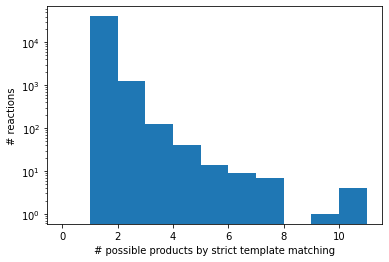

In [10]:
import matplotlib.pyplot as plt

plt.hist(num_possible_pts_list, bins=np.arange(12))
plt.xlabel('# possible products by strict template matching')
plt.ylabel('# reactions')
plt.yscale('log')

# METHOD 2 - RANDOM

In [3]:
# patience: number of trials for searching template
# i.e. depth of the search for each reaction
patience = 1

In [4]:
false_rxn_dict = {
    'rxn_smiles': [],
    'label': [],
    'true_rxn_smiles': [],
    'forward_template': []
}

for i in tqdm(range(len(df))):
# for i in [0]:
    rxn = rxn_smiles[i]
    rxn = removemap(rxn)
    rt, pt = rxn2rtpt(rxn)

    # avoid choosing same template twice
    random_temp_id = np.random.choice(len(retro_templates), size=patience, replace=False)
    possible_pts = []
    for j in random_temp_id:
        # skip if the selected template is the one associated with the reaction
        # because this situation has already been taken into consideration
        # in the STRICT template mapping method
        if df.loc[i, 'retro_template'] == retro_templates[j]:
            continue
        rule = reverse_temp(retro_templates[j])
        possible_pts += rdc.rdchiralRunText(rule, rt)

    # remove duplicates from possible_pts (if any)
    possible_pts = list(set(possible_pts))

    # look for false reactions
    for possible_pt in possible_pts:
        # for possible product that is not the recorded product
        # we take it as a negative product
        # and the corresponding reaction as a negaitve sample
        if possible_pt != pt:
            false_rxn = f'{rt}>>{possible_pt}'

            # dump essential info into dict
            false_rxn_dict['rxn_smiles'].append(false_rxn)
            false_rxn_dict['label'].append(0)
            false_rxn_dict['true_rxn_smiles'].append(rxn)
            false_rxn_dict['forward_template'].append(rule)

100%|██████████| 42043/42043 [02:33<00:00, 274.68it/s]


In [5]:
false_rxn_df = pd.DataFrame(false_rxn_dict)
print(f'{len(false_rxn_df)} false reactions were succesfully generated this time,')

negative_random = pd.read_csv('negative_random.csv')
len_negative_random = len(negative_random)

negative_random = pd.concat([negative_random, false_rxn_df])
negative_random.drop_duplicates(subset='rxn_smiles', inplace=True)
negative_random.to_csv('negative_random.csv', index=False)
print(f'{len(negative_random) - len_negative_random} out of which are new.')
print(f'In total, {len(negative_random)} false reactions were successfully generated using random template mapping.')

38 false reactions were succesfully generated this time,
29 out of which are new.
In total, 105156 false reactions were successfully generated using random template mapping.


### Draw reactions, templates and reactants (for debug purpose)

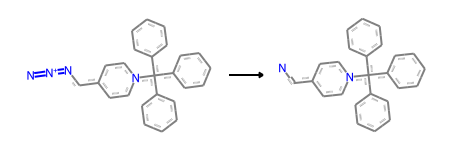

In [5]:
AllChem.ReactionFromSmarts(rxn)

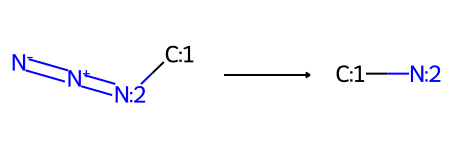

In [6]:
AllChem.ReactionFromSmarts(rule)

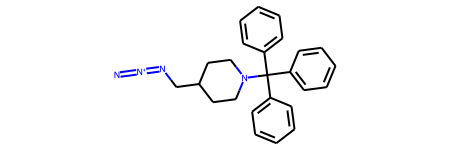

In [7]:
Chem.MolFromSmiles(rt)

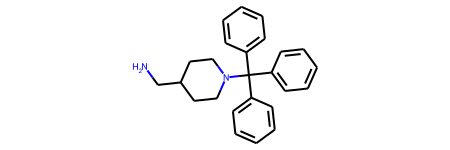

In [8]:
Chem.MolFromSmiles(pt)

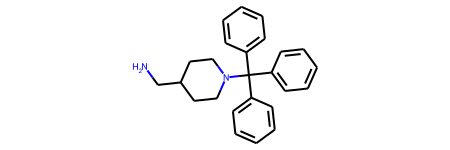

In [9]:
Chem.MolFromSmiles(possible_pts[0])